# find regions where trades are within a certain band

In [1]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import talib as ta # conda activate cryt310

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
tickerpair="ETCUSDT" #GBPUSDT #LTCUSDT #ETHUSDT #BTCUSDT
tickerpair="BNBUSDT" #BNBUSDT #AUDUSDT #XMRUSDT
interval="5m"
intervals=['1m','3m','5m','15m','30m','1h','2h','3h','4h','6h','8h','12h','1d','3d','1w','1Month']
years=sorted(set([g.split("_")[2] for g in glob(f"kline_data\\{tickerpair}/*")]))

In [2]:
%%time
df = [pd.read_csv(g) for g in sorted(glob(f"kline_data\\{tickerpair}/*")) if f"_{interval}.csv" in g]
df = pd.concat(df, ignore_index=True).drop_duplicates().reset_index(drop=True)

dfmpl=df[["open_time","open","high","low","close","volume"]]
dfmpl = dfmpl.rename(columns={"open_time":"Date","open":"Open","high":"High","low":"Low","close":"Close","volume":"Volume"})
dfmpl=dfmpl.set_index("Date")
dfmpl.index = pd.to_datetime(dfmpl.index,unit="ms")
print(len(dfmpl))
dfmpl=dfmpl.iloc[-15000:]

558343
CPU times: total: 1.28 s
Wall time: 2.34 s


In [3]:
# len(os.listdir("kline_data")),os.listdir("kline_data")

# use the gradient of the std/mean instead

<timed exec>:11: UserWarning: FixedFormatter should only be used together with FixedLocator


CPU times: total: 312 ms
Wall time: 747 ms


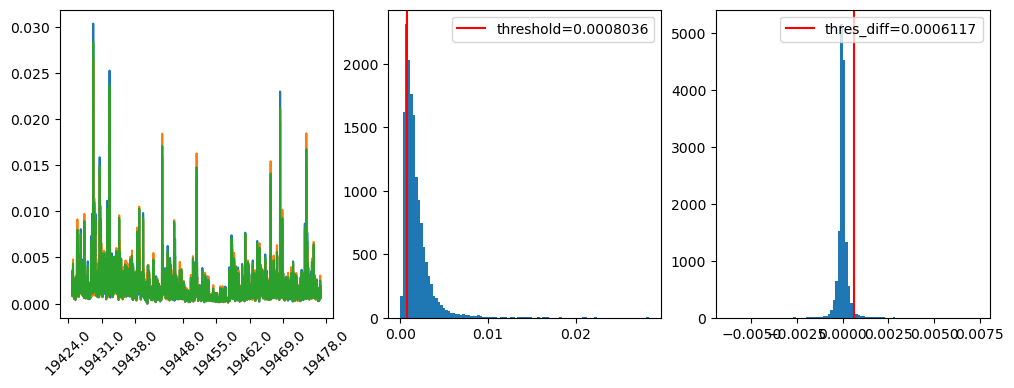

In [4]:
%%time
xvals=np.arange(len(dfmpl.Close))
rolling_high_std_mean = dfmpl.High.rolling(14).std()/dfmpl.High.rolling(14).mean()
rolling_low_std_mean = dfmpl.Low.rolling(14).std()/dfmpl.Low.rolling(14).mean()
rolling_std_mean=rolling_low_std_mean*0.5+rolling_high_std_mean*0.5
r_std_mean_diff = rolling_std_mean.diff()

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))
ax1.plot(rolling_high_std_mean)
ax1.plot(rolling_low_std_mean)
ax1.plot(rolling_std_mean)
ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)
n,bins,_ = ax2.hist(rolling_std_mean,bins=100)
thres = np.percentile(rolling_std_mean.values[np.where(~np.isnan(rolling_std_mean.values))],25)
ax2.axvline(thres,c="r",label=f"threshold={thres:.4g}")
ax2.legend()
ax3.hist(r_std_mean_diff,bins=100)
thres_diff = np.percentile(r_std_mean_diff.values[np.where(~np.isnan(r_std_mean_diff.values))],98)
#thres_diff=0.0004
ax3.axvline(thres_diff,c="r",label=f"thres_diff={thres_diff:.4g}")
ax3.legend()
#thres = 0.001
mkoffset = 1.01
crossings = np.where(np.diff(r_std_mean_diff>thres_diff,1))[0]
scatter = [ dfmpl.Close.iloc[i]*mkoffset if i in crossings else np.nan for i in xvals]
crossup=np.where(np.diff((r_std_mean_diff>thres_diff)*1.,1)>0)[0]
scatterup = [ dfmpl.Close.iloc[i]*mkoffset if i in crossup else np.nan for i in xvals]
crossdn=np.where(np.diff((r_std_mean_diff>thres_diff)*1.,1)<0)[0]
scatterdn = [ dfmpl.Close.iloc[i]*mkoffset if i in crossdn else np.nan for i in xvals]
vlines = [dfmpl.index[i] for i in xvals if i in crossings ]
my_vlines=[i for i in xvals if i in crossings ]

In [5]:
%%time
predict = [] # capture data
result= [] 
entry_exit_pairs=(np.where(~np.isnan(scatterup))[0],np.where(~np.isnan(scatterdn))[0])
for entry,exit in zip(*entry_exit_pairs):
    if entry-2<0:
        continue
    s_1 = dfmpl.iloc[entry-2]
    s = dfmpl.iloc[entry-1]
    s1 = dfmpl.iloc[entry]
    s2 = dfmpl.iloc[exit]
    predict.append( (s_1.Close-s_1.Open,s.Close-s.Open) )
    result.append( s2.Close-s.Close )
pred_sign = np.sign(predict,out=np.ones_like(np.asarray(predict))*-1.,where=np.asarray(predict)!=0)
true_sign = np.sign(result,out=np.ones_like(np.asarray(result))*-1.,where=np.asarray(result)!=0)

CPU times: total: 15.6 ms
Wall time: 59 ms


In [6]:
input_labels = [ "".join([ "1"if x>0 else "0" for x in [*i,z]]) for i,z in zip(pred_sign,true_sign) ]
#input_labels[:10],list(zip(pred_sign,true_sign))[:10]
sorted(Counter(input_labels).items())

[('000', 42),
 ('001', 7),
 ('010', 8),
 ('011', 16),
 ('100', 20),
 ('101', 14),
 ('110', 1),
 ('111', 24)]

In [7]:
def mapped(i):
    if i[:2]=="00":
        return -1
    if i[:2]=="11":
        return 1
    return 0
predicted_result = np.asarray([ mapped(i) for i in input_labels])

In [8]:
lastNsamples = int(len(result)*0.1)
print("total results=",len(result) ,"lastN",lastNsamples) 

total results= 132 lastN 13


In [9]:
%%time
profit=[] # implement backtesting for this strat
trade_durations = []
concated_df0=[]
high_low_pair = []
for entry,exit,buy in zip(*entry_exit_pairs,predicted_result): 
    s_1 = dfmpl.iloc[entry-2]
    s = dfmpl.iloc[entry-1]
    s1 = dfmpl.iloc[entry]
    s2 = dfmpl.iloc[exit]
    if buy==0:continue #if buy==-1:continue
    gains= buy*(s2.Close-s.Close)/(s.Close)
    profit.append(gains)
    # collecting trade stats
    indd=dfmpl.iloc[[entry,exit]].index
    diff = indd[1].to_datetime64()-indd[0].to_datetime64()
    trade_hr = int(diff)*1e-9/3600
    trade_durations.append( trade_hr )
    concated_df0.append( dfmpl.iloc[entry-1:exit+1] )
    high_low_pair.append( (s.Close,s2.Close,buy,
                           dfmpl.iloc[entry:exit+1].High.max(),
                           dfmpl.iloc[entry:exit+1].Low.min()) )
    #print(dfmpl.iloc[entry-1:exit+1])
    #print("*"*8,s.Close,s2.Close,buy,gains,entry,exit)


CPU times: total: 62.5 ms
Wall time: 114 ms


CPU times: total: 594 ms
Wall time: 914 ms


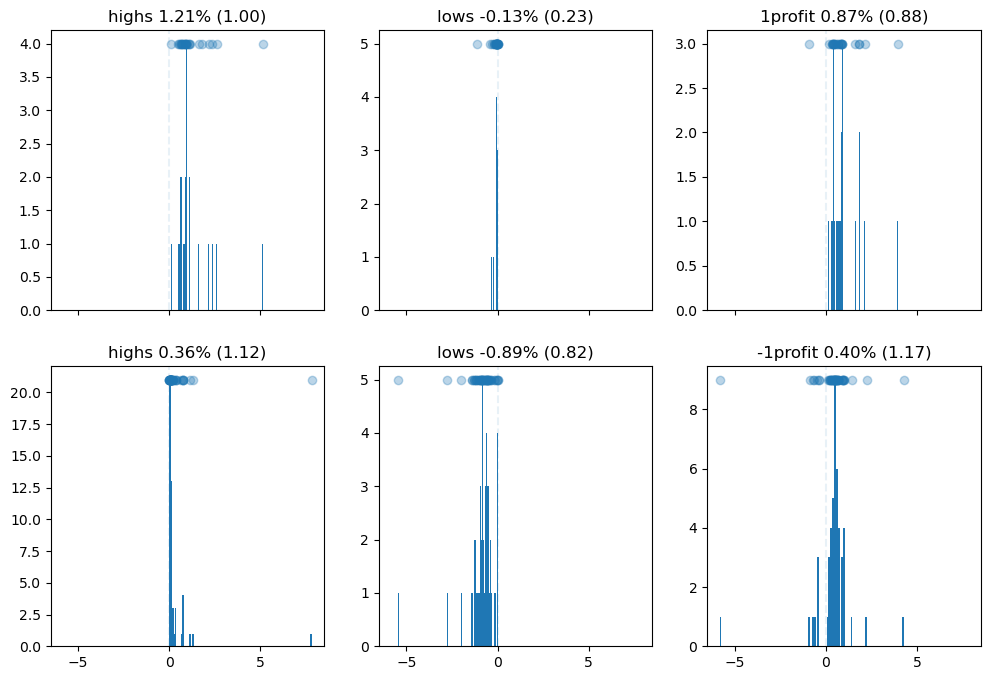

In [10]:
%%time
fig,axxx=plt.subplots(2,3,figsize=(12,8),sharex=True)
for buy_,axx in zip([1,-1],axxx):
    highs=[(high-ent)/ent*100 for ent,exi,buy,high,low in high_low_pair if buy==buy_]
    lows=[(low-ent)/ent*100 for ent,exi,buy,high,low in high_low_pair if buy==buy_]
    profit_=[buy*(exi-ent)/ent*100 for ent,exi,buy,high,low in high_low_pair if buy==buy_]

    ax=axx[0]
    n,bins,_ = ax.hist(highs,bins=100);
    ax.scatter(highs,[np.max(n)]*len(highs),alpha=0.3)
    ax.set_title(f"highs {np.mean(highs):.2f}% ({np.std(highs):.2f})")
    ax=axx[1]
    n,bins,_ = ax.hist(lows,bins=100);
    ax.scatter(lows,[np.max(n)]*len(lows),alpha=0.3)
    ax.set_title(f"lows {np.mean(lows):.2f}% ({np.std(lows):.2f})")
    ax=axx[2]
    n,bins,_ = ax.hist(profit_,bins=100);
    ax.scatter(profit_,[np.max(n)]*len(profit_),alpha=0.3)
    ax.set_title(f"{buy_}profit {np.mean(profit_):.2f}% ({np.std(profit_):.2f})")
    for ax in axx:
        ax.axvline(0,ls="--",alpha=0.1)

In [11]:
len(pred_sign),len(predict),len(result)

(132, 132, 132)

In [12]:
concated_df = pd.concat([i-i.iloc[0].Open for i in concated_df0[:20]])
l_ = 0
scatter=[]
my_vlines = [ ]
for i in concated_df0[:20]:
    my_vlines.append(l_)
    for ii in range(len(i)):
        l_ +=1
        scatter.append(np.nan)
    scatter.pop()
    scatter.append(concated_df.iloc[l_-1].Close)

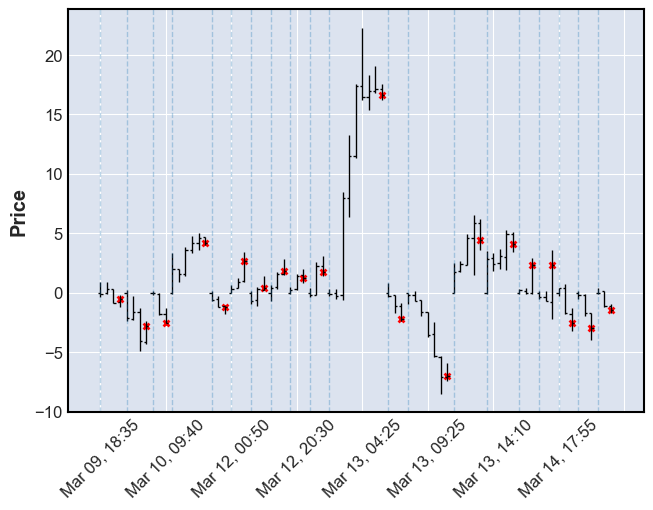

In [13]:
apds = [ 
    #mpf.make_addplot(rolling_std_mean,panel=1,color='b',type='line',ylabel=f"diff(std/mean)>thres{thres_diff:.2g}"), 
   #mpf.make_addplot(scatterup,color='g',type='scatter',marker="^"),
   mpf.make_addplot(scatter,color='r',type='scatter',marker="x"),
       ]
fig, axlist =mpf.plot(concated_df,addplot=apds, returnfig=True)
for ax in axlist[:]:
    for vline in my_vlines:
        ax.axvline(x=vline, linestyle='--',linewidth=1,alpha=0.3)

In [14]:
def get_stats(lastNsamples=0):
    final_profit = 1
    profit1=profit[-lastNsamples:]
    ind=dfmpl.iloc[np.where(~np.isnan(scatterup))[0][np.r_[-lastNsamples,-1]]].index
    equity=[1]
    for p in profit1:
        final_profit *= (1+p)
        equity.append(final_profit)
    wins=sum(p>0 for p in profit1)
    diff = ind[1].to_datetime64()-ind[0].to_datetime64()
    trading_days = int(diff)*1e-9/3600/24
    str1=f"gain% = {final_profit*100-100:.2f}%"+"\n"+\
          f"trades={len(profit1)}, wins={wins}, win%={wins/len(profit1)*100:.2f}%"+"\n"+\
          f"days={trading_days:.3g}d, trade dur={np.mean(trade_durations[-lastNsamples:]):.3g}hr"
    return str1
final_profit = 1
profit1=profit
equity=[1]
for p in profit1:
    final_profit *= (1+p)
    equity.append(final_profit)

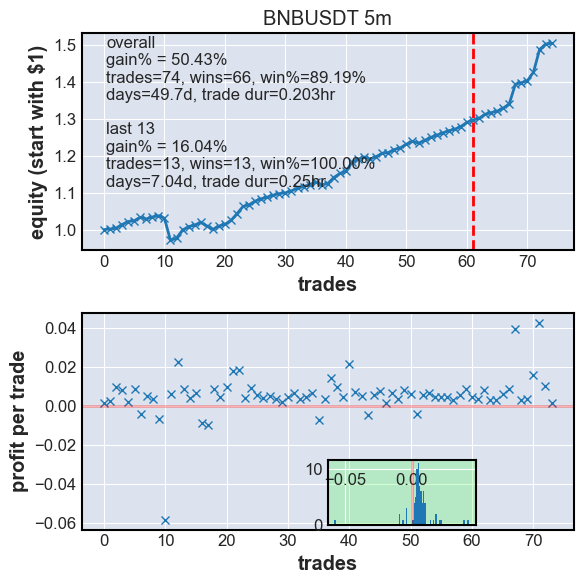

In [21]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(6,6))
ax1.plot(equity,"-x")
ax1.set_ylabel("equity (start with $1)")
ax1.set_title(
    f"{tickerpair} {interval}")
ax1.text(0.05,0.99, "overall\n"+get_stats(0),transform=ax1.transAxes,va="top",ha="left")
ax1.text(0.05,0.59, f"last {lastNsamples}\n"+get_stats(lastNsamples),transform=ax1.transAxes,va="top",ha="left")
ax1.axvline(len(profit)-lastNsamples,c="r",ls="--")
ax2.plot(profit,"x")
ax2.axhline(0,c="r",alpha=0.3)
ax2.set_ylabel("profit per trade")

for ax in (ax1,ax2):
    ax.set_xlabel("trades")
plt.tight_layout()
ax3 = ax2.inset_axes((0.5,0.02,0.3,0.3))

ax3.hist(profit,bins=100)
ax3.axvline(0,c="r",alpha=0.3)
ax3.tick_params("x",top=True, labeltop=True, bottom=False, labelbottom=False,pad=-20,direction="in")
ax3.set_facecolor('#0fff0f30')

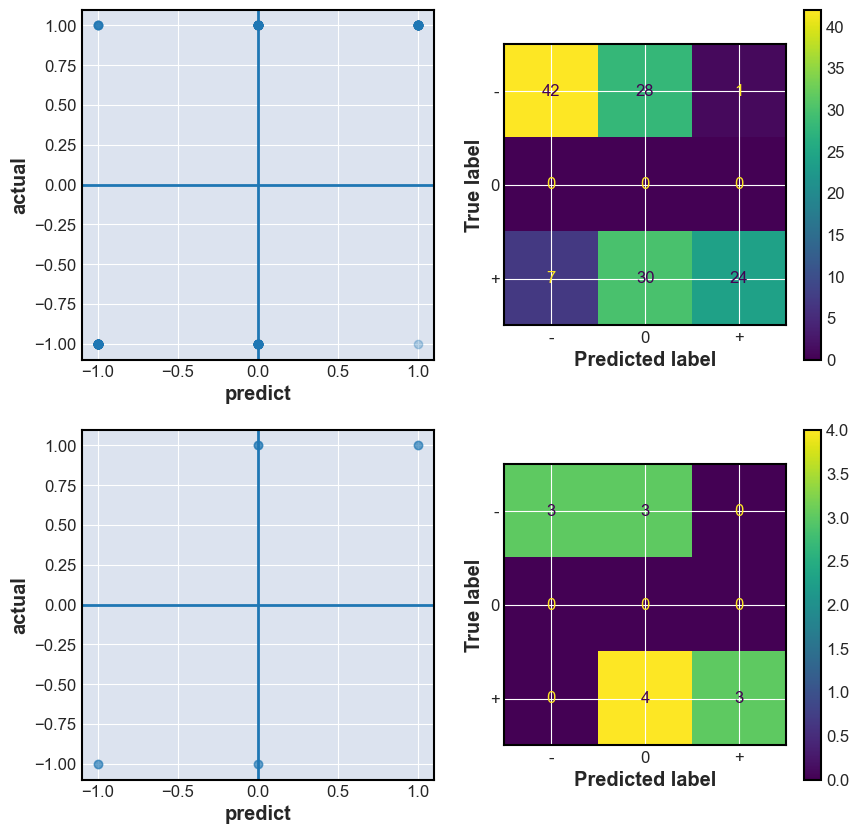

In [16]:
fig,axx=plt.subplots(2,2,figsize=(10,10))
for i,(ax1,ax2) in enumerate(axx):
    ii=0 if i==0 else lastNsamples
    ax1.scatter(predicted_result[-ii:],true_sign[-ii:],alpha=0.3)
    ax1.set_xlabel("predict")
    ax1.set_ylabel("actual")
    ax1.axvline(0)
    ax1.axhline(0)
    ConfusionMatrixDisplay.from_predictions(  true_sign[-ii:],predicted_result[-ii:],
            display_labels=["-","0","+"],ax=ax2)